## Importando bibliotecas

In [2]:
%load_ext autoreload 
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import time
import os
import pickle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Bibliotecas para treinamento
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import os
from modelagem.train import model_trainer
from pathlib import Path
import pandas as pd
from random import choice
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np

pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 100)

In [2]:
# TODO: E se criar um modelo para cada time?

## Coletando dados

In [4]:
# Definindo diretórios base
BASE_DIR = os.path.dirname(Path("__file__").resolve().parent)
DATA_DIR = os.path.join(BASE_DIR, "pred_soccer", "modelagem", 'feature_eng', 'data')
MODEL_DIR = os.path.join(os.path.dirname(BASE_DIR), 'database')
LOG_DIR = os.path.join(os.path.dirname(BASE_DIR), 'logs')

df = pd.read_csv(os.path.join(DATA_DIR, 'ft_df.csv'))
df_train = model_trainer.main(df)

2025-04-03 21:18:43,929 | main | INFO | model_trainer | split_data | Dividindo os dados com valid_year=2024 e test_size=0.3...
2025-04-03 21:18:43,933 | main | INFO | model_trainer | split_data | Tamanho dos conjuntos: Treino=3191, Teste=1368, Validação=380


In [4]:
##dropping columns one wouldn't have before an actual match
cols_to_drop = ['ls_winner', 
                ]

df.drop(columns=cols_to_drop, inplace = True)

## Funções

Agora esse pré-processamento é feito em feature-eng!!!

## Separando dados de treino e teste

Nessa etapa estamos realizando o balanceamento de dados pois o modelo está com o vies com o desbalanceamento

In [6]:
# Dividindo manualmente os dados respeitando a ordem temporal
split_index = int(len(df) * 0.8)  # Usando 80% dos dados para treino e 20% para teste

#X_train, X_test = X[:split_index], X[split_index:]
#y_train, y_test = y[:split_index], y[split_index:]

df_train = df[df['season']<2019] #['season'].value_counts()
df_test = df[(df['season']>=2019) & (df['season']<2024)]
df_valid = df[df['season']>=2024]

X_train, y_train = df_train.drop(columns=['winner', 'season']), df_train['winner']
X_test, y_test = df_test.drop(columns=['winner', 'season']), df_test['winner']
X_valid, y_valid = df_valid.drop(columns=['winner', 'season']), df_valid['winner']

# X_train, y_train = balancear_dados(X=X_train, y=y_train)

In [7]:
df_valid['season'].value_counts()

season
2024    380
Name: count, dtype: int64

In [8]:
# Como é o balanceamento da classe y

df_train['winner'].value_counts(normalize=True)

winner
2    0.502068
0    0.264385
1    0.233546
Name: proportion, dtype: float64

In [9]:
# Como é ficou balanceamento da classe y
 
y_train.value_counts(normalize=True)

winner
2    0.502068
0    0.264385
1    0.233546
Name: proportion, dtype: float64

---

In [11]:
# Acredito que romover season não é mais necessario

# df.drop(columns=['season'], inplace=True)

## Listagem de modelos

In [43]:
class RandomModel:
    def __init__(self):
        pass

    def fit(self, x_train, y_true):
        self.y_true = y_true

    def predict(self, X):
        pred = [np.random.choice(self.y_true) for i in range(len(X))]
        return  np.array(pred)
    
model = RandomModel()
model.fit([1, 2, 3], [1, 2, 3])
predictions = model.predict([1, 2, 3])
predictions

array([1, 1, 1])

In [46]:
np.random.seed(101)

# Creating models variable to iterate through each model and print result
list_model = [
    {'algorithm':'Logistic Regression', 'model':LogisticRegression(max_iter=3000)},
    {'algorithm':'Logistic Regression tune', 'model':LogisticRegression(C=100, max_iter=3000, solver='newton-cg')},
    {'algorithm':'Random Forest', 'model':RandomForestClassifier(class_weight='balanced')},
    {'algorithm':'Gradient Boost', 'model':GradientBoostingClassifier()},
    {'algorithm':'KNN', 'model':KNeighborsClassifier()},
    {'algorithm':'Naive Bayes', 'model':GaussianNB()},
    #{'algorithm':'SVM', 'model':SVC()},
    {'algorithm':'Decision Tree (C5)', 'model':DecisionTreeClassifier(
                                                max_depth=48, 
                                                min_samples_split=19, 
                                                min_samples_leaf=6, 
                                                max_features='log2', 
                                                criterion='gini')},
                                        
    {'algorithm':'Neural Network (MLP)', 'model':MLPClassifier(max_iter=3000)},
    {'algorithm':'XGBoost', 'model':XGBClassifier()},
    {'algorithm':'XGBoost tune', 'model':XGBClassifier(
                                                max_depth=3, 
                                                learning_rate=0.1, 
                                                n_estimators=100, 
                                                objective='binary:logistic', 
                                                booster='gbtree', 
                                                gamma=0.1, 
                                                min_child_weight=1, 
                                                subsample=0.8, 
                                                colsample_bytree=0.8, 
                                                random_state=42)},
    {'algorithm':'Random', 'model':RandomModel()},

    

    
    ]
        #'XGBoost': XGBClassifier(),
        #'Multiple Linear Regression': LinearRegression(),



## Funções úteis

Funções de teste

In [38]:
# Creating loop to test which set of features is the best one for Logistic Regression
def get_best_num_feature():
    """
    Objetivo: Identificar o desempenho testando com varios numeros de features
    """
    acc_results = []
    n_features = []

    scaler = MinMaxScaler()

    # best classifier on training data
    clf = list_model[0]['model']

    #X = df.drop(columns='winner')
    #y = df['winner']

    for i in range(12, len(X_train.columns)):
        rfe = RFE(estimator=clf, n_features_to_select=i, step=1)
        rfe.fit(X_train, y_train)
        X_temp = rfe.transform(X)

        np.random.seed(101)

        #X_train, X_test, y_train, y_test = train_test_split(X_temp,y, test_size = 0.2)

        X_train_trans = scaler.fit_transform(X_train)
        X_test_trans = scaler.fit_transform(X_test)

        start = time.time()
        scores = cross_val_score(clf, X_train_trans, y_train ,scoring= 'accuracy', cv=5)
        print(f"Clf result : {scores.mean()}, +- {scores.std()} N_features: {i}")
        acc_results.append(scores.mean())
        n_features.append(i)

    plt.plot(n_features, acc_results)
    plt.ylabel('Accuracy')
    plt.xlabel('N features')
    plt.show()

In [39]:
def get_data_transform(X:pd.DataFrame, get_y_true=False):
    """
    Recebe dataframe e retorna o dado pronto para ser realizado a predição
    """

    #columns_pred = rfe.feature_names_in_

    #X_valid = df_valid.drop(columns=['winner', 'season'])

    #X_valid_trans = rfe.transform(df_valid[columns_pred])

    scaler = MinMaxScaler()

    X_valid_trans_scaler = scaler.fit_transform(X)

    if get_y_true:
        y_valid = X['winner']
        return X_valid_trans_scaler, y_valid

    return pd.DataFrame(X_valid_trans_scaler, columns=X.columns) 


def pred_data_valid(df_valid, rfe):
    X_valid_trans_scaler = get_data_transform(df_valid, rfe)

Funções de metricas

In [ ]:
def calc_f1(precision, recal):
    if precision + recal == 0:
        return 0
    return round(2 * ((precision * recal) / (precision + recal)), 2)

def calc_recal(tp_count, fn_count):
    if tp_count+fn_count == 0:
        return 0
    return round(tp_count / (tp_count+fn_count), 2)

def calc_precision(tp_count, fp_count):
    if tp_count+fp_count == 0:
        return 0
    return round(tp_count / (tp_count+fp_count), 2)

def metrics_per_class(df_preds, classe):
    """
        Realiza do calculos e de diversas metricas
    """
    # Filtrar as predições e os rótulos verdadeiros para a classe atual
    # True Positives (TP): Previsão correta de que a instância pertence à classe (ou seja, y_pred == classe e y_true == classe).
    true_positives = df_preds[(df_preds['y_pred'] == classe) & (df_preds['y_true'] == classe)]

    # True Negatives (TN): Previsão correta de que a instância não pertence à classe (ou seja, y_pred != classe e y_true != classe).
    true_negatives = df_preds[(df_preds['y_pred'] != classe) & (df_preds['y_true'] != classe)]

    # False Positives (FP): Previsão errada de que a instância pertence à classe, quando na verdade não pertence (ou seja, y_pred == classe e y_true != classe).
    false_positives = df_preds[(df_preds['y_pred'] != classe) & (df_preds['y_true'] == classe)]

    # False Negatives (FN): Previsão errada de que a instância não pertence à classe, quando na verdade pertence (ou seja, y_pred != classe e y_true == classe).
    false_negatives = df_preds[(df_preds['y_pred'] == classe) & (df_preds['y_true'] != classe)]

    # Contagem de cada um
    tp_count = len(true_positives)
    tn_count = len(true_negatives)
    fp_count = len(false_positives)
    fn_count = len(false_negatives)
    
    precision = calc_precision(tp_count, fp_count)
    recal = calc_recal(tp_count, fn_count)
    F1 = calc_f1(precision, recal)

    return {"precision":precision, "recal":recal, "F1":F1}

# def get_metrics_multiclass(y_pred:list, y_true:list):
#     """ 

#     Realiza o calculo de varias metricas para cada classe

#     Calcular a precisão: TP / (TP + FP)

#     RETURN: {np.int64(0): 0.33, np.int64(2): 0.57, np.int64(1): 0.3}
#     """
#     df_preds = pd.DataFrame(columns=['y_pred', 'y_true'])
#     df_preds['y_pred'] = y_pred
#     df_preds['y_true'] = y_true

#     dict_precision = {}

#     for classe in df_preds['y_true'].unique():
#         dict_metrics_per_class = metrics_per_class(df_preds, classe)

#         #precision, recal, F1
#         dict_precision[classe] = dict_metrics_per_class

#     return dict_precision

# def get_precision_multiclass(metrics_multiclass):
#     return {metrics:metrics_multiclass[metrics]['precision'] for metrics in metrics_multiclass}

# def show_print_precision_multiclass(precision_multiclass, algorithm_name=''):
#     """
#         Exibe de uma baneira mais visual as metricas de precisão
#     """
#     home_team_precision = precision_multiclass.get(2, 0)
#     draw_precision = precision_multiclass.get(0, 0)
#     away_team_precision = precision_multiclass.get(1, 0)

#     print(f'''Reultados: ({algorithm_name})
#     Home_team: ------ {round(home_team_precision*100, 2)}%
#     Draw: ----------- {round(draw_precision*100, 2)}%
#     Away_team: ------ {round(away_team_precision*100, 2)}%
#     ----------------------------''')

# def get_precision(y_pred:list, y_true:list):
#     """
#     Objetivo: Obtem a precisão

#     Calcular a precisão: TP / (TP + FP)
#     """
#     all_predicted = len(y_true)
#     true_positives = sum(y_pred == y_true)
#     precision = true_positives / all_predicted

#     return precision

y_pred = np.array([2, 1, 9, 4, 5, 6, 7, 8, 9, 10])
y_true = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
get_precision(y_pred=y_pred,
              y_true=y_true
                )

y_pred = np.array([1, 1, 1, 1, 0,
                   0, 2, 2, 2, 2,
                   0, 1])

y_pred = np.array([0, 0, 0, 0, 0,
                   0, 2, 2, 2, 2,
                   0, 0])

y_true = np.array([1, 1, 1, 1, 1,
                   0, 2, 2, 2, 2,
                   0, 1])


# Existe apenas um 3 e eu acertei, mas a classe 3 saiu prejudicada
# Quem deve sair prejudicado nesse exemplo é a classe 1
metrics_multiclass = get_metrics_multiclass(y_pred=y_pred, 
                        y_true=y_true)

precision_multiclass = get_precision_multiclass(metrics_multiclass)
show_print_precision_multiclass(precision_multiclass=precision_multiclass, algorithm_name='Algo aqui')
                        

Reultados: (Algo aqui)
    Home_team: ------ 100.0%
    Draw: ----------- 100.0%
    Away_team: ------ 0.0%
    ----------------------------


In [ ]:
from modelagem.utils.metrics import get_metrics_multiclass, show_print_precision_multiclass

In [14]:
# TODO: Obter as features onde tenho mais desempenho em minhas features
sampled_columns = X_train.columns.to_series().sample(n=30, random_state=1).tolist()

## Cross Validation

Passo para escolher o modelo que tem o melhor desempenho



In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit # Essa técnica garante que os dados de treinamento estejam sempre antes dos dados de teste. O TimeSeriesSplit é uma forma de validação cruzada que preserva a ordem temporal dos dados.

import numpy as np

import time

def run_cross_val_score(list_model, X, y, is_x_transform=False):
    """
    O objetivo aqui é encontrar os melhores modelos
    """
    results = []
    for dict_model in list_model:
        # X, y = balancear_dados(X=X, y=y, mode='subamostragem')

        if is_x_transform:
            X = get_data_transform(X, get_y_true=False)
            

        # Inicializar o modelo
        clf = dict_model['model']

        # Número de splits para o TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)
        fold_predictions = []
        fold_true_values = []

        list_accuracy = []
        start = time.time()
        for idx, (train_index, test_index) in enumerate(tscv.split(X), start=0):
            X_kf_train, X_kf_test = X.iloc[train_index], X.iloc[test_index]
            y_kf_train, y_kf_test = y.iloc[train_index], y.iloc[test_index]
            
            clf.fit(X_kf_train, y_kf_train)
            y_kf_pred = clf.predict(X_kf_test)
            
            fold_predictions.append(y_kf_pred)
            fold_true_values.append(y_kf_test.values)
            
            # Você também pode calcular e armazenar a acurácia para cada fold
            accuracy = accuracy_score(y_kf_test, y_kf_pred)
            list_accuracy.append(accuracy)
            #print(f'idx: {idx}, Fold accuracy: {accuracy}')

        mean_score = round(np.array(list_accuracy).mean(), 2)
        std_score = round(np.array(list_accuracy).std(), 2)
        algorithm = dict_model['algorithm']
        elapsed_time = round(time.time() - start, 2)

        
        print(f'algorithm: {algorithm} | Media e Desvio: {mean_score}% +- {std_score}% | Elapsed time: {round(elapsed_time, 2)}s')
        
        results.append({'algorithm': algorithm, 
                        'mean_accuracy': mean_score, 
                        'std_accuracy': std_score, 
                        'elapsed_time': elapsed_time,
                        
                        'fold_predictions': fold_predictions[0],
                        'fold_true_values': fold_true_values[0],
                        'list_accuracy': list_accuracy,
                        
                        })
        #break
        
        #except Exception as e:
        #    print(f'Error with {algorithm}: {e}')
    
    return results

# Exemplo de uso

clf = list_model[0]['model']

#columns_selected_0 = ["at_loss_streak",    
#                    "at_l_wavg_goals",   
#                    "ht_l_points",       
#                    "at_l_wavg_points",  
#                    "ht_points",         
#                    "at_l_goals_sf",     
#                    "at_wins",           
#                    "ht_l_wavg_goals",   
#                    "ht_rank",           
#                    "at_rank",           
#                    "ht_days_ls_match",  
#                    "ht_losses",]



X=df[X_train.columns]
#X=df[columns_selected_0]
y=df['winner']



list_results = run_cross_val_score(list_model=list_model, 
                              X=X, 
                              y=y,
                              is_x_transform=True)

# Dados de exemplo
# 
# TODO: rodar o kfold e em seguida plotar os resultados
# TODO: Adicionar informação que qual time está jogando pode ser útil
# Realiza o balanceamento entre as classe y
# subamostragem
# superamostragem
# combinado

# FIXME: Estou optando por realizar o corde de dados pois há uma grende diferença entre o balanceamento das classes
    # O que acaba afetando no momento da previsão, pois melhora significativamente, o que eu ACHO que pode ser um erro
    # Além disso, a superamostragem não resulveu o problema do desempenho do balanceamento, os modelo continuam com o vies



algorithm: Logistic Regression | Media e Desvio: 0.52% +- 0.01% | Elapsed time: 0.14s
algorithm: Logistic Regression tune | Media e Desvio: 0.51% +- 0.02% | Elapsed time: 0.14s
algorithm: Random Forest | Media e Desvio: 0.5% +- 0.02% | Elapsed time: 3.01s
algorithm: Gradient Boost | Media e Desvio: 0.5% +- 0.02% | Elapsed time: 13.2s
algorithm: KNN | Media e Desvio: 0.43% +- 0.02% | Elapsed time: 0.18s
algorithm: Naive Bayes | Media e Desvio: 0.45% +- 0.02% | Elapsed time: 0.03s
algorithm: Decision Tree (C5) | Media e Desvio: 0.41% +- 0.02% | Elapsed time: 0.05s
algorithm: Neural Network (MLP) | Media e Desvio: 0.47% +- 0.03% | Elapsed time: 13.2s
algorithm: XGBoost | Media e Desvio: 0.49% +- 0.02% | Elapsed time: 1.97s
algorithm: XGBoost tune | Media e Desvio: 0.51% +- 0.02% | Elapsed time: 0.97s
algorithm: random | Media e Desvio: 0.38% +- 0.01% | Elapsed time: 0.07s


In [18]:
# algorithm: Logistic Regression | Media e Desvio: 0.46% +- 0.01% | Elapsed time: 4.34s
# algorithm: Logistic Regression tune | Media e Desvio: 0.46% +- 0.01% | Elapsed time: 0.67s
# algorithm: Random Forest | Media e Desvio: 0.42% +- 0.02% | Elapsed time: 5.14s
# algorithm: Gradient Boost | Media e Desvio: 0.44% +- 0.02% | Elapsed time: 22.72s
# algorithm: KNN | Media e Desvio: 0.37% +- 0.01% | Elapsed time: 0.31s
# algorithm: Naive Bayes | Media e Desvio: 0.41% +- 0.02% | Elapsed time: 0.05s
# algorithm: Decision Tree (C5) | Media e Desvio: 0.37% +- 0.01% | Elapsed time: 0.08s
# algorithm: Neural Network (MLP) | Media e Desvio: 0.41% +- 0.02% | Elapsed time: 11.94s
# algorithm: XGBoost | Media e Desvio: 0.41% +- 0.02% | Elapsed time: 2.49s

In [63]:
# metrics_ metrics_multiclass.get(0, None)

# for results in list_results:
    # algorithm_name = results['algorithm']
    # y_pred = results['fold_predictions']
    # y_true = results['fold_true_values']

In [79]:
# Inicializando uma lista para armazenar os dados antes de criar o DataFrame
all_metrics = []

for results in list_results:
    metrics_multiclass = get_metrics_multiclass(
        y_pred=results['fold_predictions'], 
        y_true=results['fold_true_values']
    )
    
    # Iterando pelas classes (home_team, draw, away_team)
    for class_label, class_metrics in metrics_multiclass.items():
        class_metrics["results"] = {2: "home_team", 0: "draw", 1: "away_team"}.get(class_label, "unknown")
        class_metrics["algorithm"] = results['algorithm']
        all_metrics.append(class_metrics)

# Criando o DataFrame a partir da lista de métricas
df_all_metrics = pd.DataFrame(all_metrics)

In [ ]:
df_all_metrics.

,precision,recal,F1,results,algorithm
0,0.27,0.39,0.32,away_team,Logistic Regression
1,0.22,0.27,0.24,draw,Logistic Regression
2,0.76,0.63,0.69,home_team,Logistic Regression
3,0.24,0.37,0.29,away_team,Logistic Regression tune
4,0.34,0.24,0.28,draw,Logistic Regression tune
5,0.63,0.65,0.64,home_team,Logistic Regression tune
6,0.28,0.44,0.34,away_team,Random Forest
7,0.16,0.32,0.21,draw,Random Forest
8,0.81,0.59,0.68,home_team,Random Forest
9,0.29,0.37,0.33,away_team,Gradient Boost


In [47]:
for results in list_results:
    metrics_multiclass = get_metrics_multiclass(y_pred=results['fold_predictions'], 
                           y_true=results['fold_true_values'])
    
    precision_multiclass = get_precision_multiclass(metrics_multiclass=metrics_multiclass)

    print_precision_multiclass = show_print_precision_multiclass(precision_multiclass,algorithm_name=results['algorithm'])

    #print(print_precision_multiclass)

Reultados: (Logistic Regression)
    Home_team: ------ 76.0%
    Draw: ----------- 22.0%
    Away_team: ------ 27.0%
    ----------------------------
Reultados: (Logistic Regression tune)
    Home_team: ------ 63.0%
    Draw: ----------- 34.0%
    Away_team: ------ 24.0%
    ----------------------------
Reultados: (Random Forest)
    Home_team: ------ 81.0%
    Draw: ----------- 16.0%
    Away_team: ------ 28.0%
    ----------------------------
Reultados: (Gradient Boost)
    Home_team: ------ 70.0%
    Draw: ----------- 24.0%
    Away_team: ------ 29.0%
    ----------------------------
Reultados: (KNN)
    Home_team: ------ 49.0%
    Draw: ----------- 35.0%
    Away_team: ------ 28.0%
    ----------------------------
Reultados: (Naive Bayes)
    Home_team: ------ 48.0%
    Draw: ----------- 22.0%
    Away_team: ------ 50.0%
    ----------------------------
Reultados: (Decision Tree (C5))
    Home_team: ------ 59.0%
    Draw: ----------- 26.0%
    Away_team: ------ 19.0%
    ----------

In [ ]:
# Reultados: (Logistic Regression)
#     Home_team: ------ 70.0%
#     Draw: ----------- 7.0%
#     Away_team: ------ 57.0%
#     ----------------------------
# Reultados: (Logistic Regression tune)
#     Home_team: ------ 71.0%
#     Draw: ----------- 10.0%
#     Away_team: ------ 50.0%
#     ----------------------------
# Reultados: (Random Forest)
#     Home_team: ------ 48.0%
#     Draw: ----------- 20.0%
#     Away_team: ------ 51.0%
#     ----------------------------
# Reultados: (Gradient Boost)
#     Home_team: ------ 49.0%
#     Draw: ----------- 24.0%
#     Away_team: ------ 50.0%
#     ----------------------------
# Reultados: (KNN)
#     Home_team: ------ 27.0%
#     Draw: ----------- 42.0%
#     Away_team: ------ 44.0%
#     ----------------------------
# Reultados: (Naive Bayes)
#     Home_team: ------ 47.0%
#     Draw: ----------- 19.0%
#     Away_team: ------ 46.0%
#     ----------------------------
# Reultados: (Decision Tree (C5))
#     Home_team: ------ 40.0%
#     Draw: ----------- 33.0%
#     Away_team: ------ 40.0%
#     ----------------------------
# Reultados: (Neural Network (MLP))
#     Home_team: ------ 80.0%
#     Draw: ----------- 4.0%
#     Away_team: ------ 44.0%
#     ----------------------------
# Reultados: (XGBoost)
#     Home_team: ------ 49.0%
#     Draw: ----------- 25.0%
#     Away_team: ------ 45.0%
#     ----------------------------


## Gerando resultados aleatorios

In [20]:
# Gerando resultados aleatorios

random_predictions = [choice([0, 1, 2]) for i in range(1000)]
random_true_values = [choice([0, 1, 2]) for i in range(1000)]

get_metrics_multiclass(y_pred=random_predictions, y_true=random_true_values)

{np.int64(2): {'precision': 0.36, 'recal': 0.34, 'F1': 0.35},
 np.int64(1): {'precision': 0.32, 'recal': 0.33, 'F1': 0.32},
 np.int64(0): {'precision': 0.31, 'recal': 0.31, 'F1': 0.31}}

---

Tratando dados 

- Transformando e usando scaler

In [21]:
selectec_columns_h = [
                "at_wins",
                "at_l_wavg_points",
                "ht_l_points",
                "at_loss_streak",
                "ht_points",
                "at_l_goals_sf",
                "at_l_wavg_goals",
                "ht_losses",
                "ht_days_ls_match",
                "ht_l_wavg_goals",
                "at_rank",
                "ht_rank",
                "at_draws",
                "at_win_streak",
                "at_ls_rank"]


X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

X_train_copy = X_train_copy#[selectec_columns_h]
X_test_copy = X_test_copy#[selectec_columns_h]

In [22]:
abs(len(X_train_copy.columns)/2)

18.5

In [23]:


X_train_trans_scaler = get_data_transform(X_train_copy, get_y_true=False)
X_test_trans_scaler = get_data_transform(X_test_copy, get_y_true=False)

In [24]:
# column importances for each class

# Se eu quisar prever apenas EMPATES, tenho mais ganho 

# TODO: Seria útil analisar um gráfico de correlação para ver quais colunas influenciam 
from sklearn.feature_selection import RFE
import pandas as pd
import numpy as np

# Função para realizar RFE e retornar colunas importantes
def perform_rfe(clf, X_train, y_train, num_columns):
    """
    Realiza a Recursive Feature Elimination (RFE) para selecionar as features mais importantes.

    Args:
    clf: O classificador base utilizado para RFE.
    X_train: Dados de treino.
    y_train: Labels correspondentes ao treino.
    num_columns: Número de colunas a serem selecionadas.

    Returns:
    featured_columns: Lista das colunas selecionadas como importantes.
    rfe: Objeto RFE treinado.
    """
    rfe = RFE(estimator=clf, n_features_to_select=num_columns, step=1)
    rfe.fit(X_train, y_train)
    
    # Pegando os nomes das colunas selecionadas
    featured_columns = pd.DataFrame(rfe.support_,
                                    index=X_train.columns,
                                    columns=['is_in'])
    
    featured_columns = featured_columns[featured_columns.is_in == True].index.tolist()
    
    return featured_columns, rfe

# Função para calcular a importância das features
def calculate_feature_importances(rfe, featured_columns):
    """
    Calcula as importâncias das features selecionadas usando os coeficientes do modelo.

    Args:
    rfe: Objeto RFE treinado.
    featured_columns: Lista das colunas selecionadas.

    Returns:
    importances: Dicionário com as importâncias das features para cada classe.
    """
    # Exponenciando os coeficientes para cada classe (multiclasse)
    importances = {}
    for idx, class_coef in enumerate(rfe.estimator_.coef_):
        importance_df = pd.DataFrame(np.exp(class_coef),
                                     index=featured_columns,
                                     columns=['coef']).sort_values('coef', ascending=False)
        importances[f'class_{idx}'] = importance_df
    
    return importances

# Aplicando o RFE
clf = list_model[0]['model']
num_columns = len(X_train_copy.columns)

# Obtenção das colunas selecionadas e RFE treinado
featured_columns, rfe = perform_rfe(clf, X_train_copy, y_train, num_columns=num_columns)

# Cálculo das importâncias das features para cada classe
importances = calculate_feature_importances(rfe, featured_columns)

# Exibindo as importâncias para cada classe
for class_name, importance_df in importances.items():
    print(f"Importâncias das features para {class_name}:")
    print(importance_df)
    print("\n")


Importâncias das features para class_0:
                        coef
at_wins             1.179542
at_l_wavg_points    1.122434
at_loss_streak      1.066066
ht_l_points         1.055765
at_l_goals_sf       1.055585
ht_points           1.053262
at_l_wavg_goals     1.047749
ht_losses           1.028276
ht_l_wavg_goals     1.023489
at_rank             1.013795
at_draws            1.011897
ht_days_ls_match    1.011351
ht_rank             1.006518
rodada              1.002087
at_ls_rank          1.000020
ht_l_goals          0.999814
ht_goals            0.999443
ht_ls_rank          0.998671
ht_goals_sf         0.998596
at_goals_sf         0.998298
at_l_goals          0.994356
ht_l_goals_sf       0.991112
at_days_ls_match    0.988986
at_goals            0.983164
at_win_streak       0.982328
ht_loss_streak      0.976708
ht_draws            0.968172
at_losses           0.964970
at_draw_streak      0.959451
ht_win_streak       0.955041
ht_l_wavg_points    0.952687
at_points           0.950729
at_

In [25]:
print('Desempenho usando os dados de teste')

# Modelos com Sem fine tune, só peguei e rodei

def train_models(list_model, X_train_trans_scaler):
    
    for dict_model in list_model:
        mdl = dict_model['model'].fit(X_train_trans_scaler, y_train)

        y_pred = mdl.predict(X_test_trans_scaler)
        acc = round(accuracy_score(y_pred=y_pred, y_true=y_test.values), 2)
        
        metrics_multiclass = get_metrics_multiclass(y_pred=y_pred, 
                        y_true=y_test.values)
        dict_precision = get_precision_multiclass(metrics_multiclass=metrics_multiclass)
        dict_model['home_precision_%'] = dict_precision.get(2, None)
        dict_model['draw_precision_%'] = dict_precision.get(0, None)
        dict_model['away_precision_%'] = dict_precision.get(1, None)
        dict_model['mdl'] = mdl 
        dict_model['accuracy_%'] = acc
        dict_model['pred'] = y_pred

        #print(f'{dict_model["algorithm"]}: {acc}%')

    return pd.DataFrame(list_model)

df_results = train_models(list_model, X_train_trans_scaler)

#df_results

Desempenho usando os dados de teste


In [26]:
# Figura 2 

# Gerando resultados aleatorios

num_lines = X_train_trans_scaler.shape[0]
random_predictions = [choice([0, 1, 2]) for i in range(num_lines)]
random_true_values = [choice([0, 1, 2]) for i in range(num_lines)]

result_aleatorio = get_metrics_multiclass(y_pred=random_predictions, y_true=random_true_values)

algorithm = 'Aleatorio'
home_precision, home_recal, home_f1 = result_aleatorio[1].values()
draw_precision, draw_recal, draw_f1 = result_aleatorio[0].values()
away_precision, away_recal, away_f1 = result_aleatorio[2].values()

accuracy = round(accuracy_score(y_pred=random_predictions,
                           y_true=random_true_values), 2)

df_result_aleatorio = pd.DataFrame([{"algorithm":algorithm,
                "home_precision_%":home_precision,
                "draw_precision_%":draw_precision,
                "away_precision_%":away_precision,
                "accuracy_%":accuracy}])


# Removendo linhas indesejadas
df_results.drop(index=1, inplace=True)

# Melhorando porcentagens
df_results = pd.concat([df_results, df_result_aleatorio]) 
df_results[['home_precision_%','draw_precision_%','away_precision_%','accuracy_%']] = df_results[['home_precision_%','draw_precision_%','away_precision_%','accuracy_%']] * 100
df_results[['algorithm','home_precision_%','draw_precision_%','away_precision_%','accuracy_%']].sort_values(by='accuracy_%', ascending=False).reset_index(drop=True)

,algorithm,home_precision_%,draw_precision_%,away_precision_%,accuracy_%
0,Logistic Regression,57.0,31.0,53.0,49.0
1,Naive Bayes,49.0,32.0,45.0,43.0
2,Neural Network (MLP),43.0,32.0,56.0,43.0
3,Gradient Boost,44.0,28.0,52.0,42.0
4,Random Forest,37.0,34.0,52.0,40.0
5,XGBoost,31.0,34.0,56.0,38.0
6,KNN,31.0,43.0,41.0,37.0
7,Decision Tree (C5),27.0,36.0,47.0,34.0
8,Aleatorio,31.0,34.0,33.0,33.0


### Ensemble

In [27]:
def concat_preds(list_model):

    dict_concat_preds = {}
    for idx in range(len(list_model)):
        
        dict_concat_preds[list_model[idx]['algorithm']] = list_model[idx]['pred']

    df_concat_preds = pd.DataFrame(dict_concat_preds)
    return df_concat_preds

df_concat_preds = concat_preds(list_model)
df_concat_preds.head()


,Logistic Regression,Logistic Regression tune,Random Forest,Gradient Boost,KNN,Naive Bayes,Decision Tree (C5),Neural Network (MLP),XGBoost
0,1,1,1,1,1,1,1,1,1
1,0,0,1,1,0,0,1,0,0
2,2,2,0,2,0,0,1,1,2
3,0,0,1,1,1,0,2,1,0
4,2,2,2,0,1,2,1,2,1


In [28]:
def create_model_ensemble(df_concat_preds, y_true):
    for idx, row in df_concat_preds.iterrows():
        pred_mode = row.mode()
            # Verificando se a moda é unimodal (apenas um valor)
        if len(pred_mode) == 1:
            # Se for unimodal, pegue o valor
            result = pred_mode.item()
            df_concat_preds.loc[idx, 'pred_mode'] = result
        else:
            # Se for bimodal ou multimodal, trate como necessário (por exemplo, retornando None)
            result = row['Logistic Regression']
            df_concat_preds.loc[idx, 'pred_mode'] = result

    df_concat_preds['pred_mode'] = df_concat_preds['pred_mode'].astype(int)
    df_concat_preds['y_true'] = y_true.values

    return df_concat_preds


df_concat_preds = create_model_ensemble(df_concat_preds, y_true=y_test)

df_concat_preds.head()

,Logistic Regression,Logistic Regression tune,Random Forest,Gradient Boost,KNN,Naive Bayes,Decision Tree (C5),Neural Network (MLP),XGBoost,pred_mode,y_true
0,1,1,1,1,1,1,1,1,1,1,0
1,0,0,1,1,0,0,1,0,0,0,2
2,2,2,0,2,0,0,1,1,2,2,2
3,0,0,1,1,1,0,2,1,0,0,2
4,2,2,2,0,1,2,1,2,1,2,2


In [29]:
# Estou tendo muito falsos positivos para as entre classes
# Exemplo: se eu filtrar a classe 0 e dar um value_counts eu consigo observerar 
#   o seguinte comportamento pred_mode:{2:61%, 0:21%, 1:17%}
#   Essa proporção é semelhante a proporção global onde o time visitente(2) tem 
#   mais dados/chance de ganhar do que o time visitante 

# Ou sejá, o modelo aprendeu o padrão das proporções, mas não aprendeu padrão pra chegar 
#   no resultado real para cada classe
df_concat_preds[df_concat_preds['y_true']==0]['pred_mode'].value_counts(normalize=True)



pred_mode
1    0.365714
2    0.323810
0    0.310476
Name: proportion, dtype: float64

In [30]:
df_concat_preds['acertos_mode'] = df_concat_preds['pred_mode'] == df_concat_preds['y_true']
df_concat_preds['acertos_mode'].value_counts(normalize=True)

acertos_mode
False    0.534211
True     0.465789
Name: proportion, dtype: float64

In [31]:
metrics_multiclass = get_metrics_multiclass(y_pred=df_concat_preds['pred_mode'], 
                        y_true=y_test.values)
precision_multiclass = get_precision_multiclass(metrics_multiclass=metrics_multiclass)

show_print_precision_multiclass(precision_multiclass=precision_multiclass)

Reultados: ()
    Home_team: ------ 51.0%
    Draw: ----------- 31.0%
    Away_team: ------ 55.0%
    ----------------------------


### Usando dados de validação

In [32]:
X_valid.head()

,rodada,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_points,ht_goals,ht_l_goals,ht_l_wavg_goals,ht_goals_sf,ht_l_goals_sf,ht_l_wavg_goals_sf,ht_wins,ht_draws,ht_losses,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_points,at_goals,at_l_goals,at_l_wavg_goals,at_goals_sf,at_l_goals_sf,at_l_wavg_goals_sf,at_wins,at_draws,at_losses,at_win_streak,at_loss_streak,at_draw_streak
3609,3,11,7.0,3.0,3,1.000000,1.500000,4,1.333333,2.000000,2,0.000000,1.000000,1,0,1,0,1,0,13,9.0,3.0,6,2.000000,3.000000,3,1.000000,1.500000,1,0.666667,0.500000,2,0,0,2,0,0
3610,3,17,-33.0,5.0,11,0.333333,0.239258,19,6.333333,1.005615,24,7.333333,1.801025,2,5,7,0,2,0,2,10.0,4.0,28,3.000000,2.886841,20,6.666667,2.618958,16,3.333333,0.975342,8,4,3,4,0,0
3611,5,10,6.0,6.0,8,2.333333,1.750000,6,2.000000,1.250000,4,1.333333,0.875000,2,2,0,0,0,1,5,4.0,6.0,7,1.333333,1.000000,4,1.333333,0.500000,4,1.666667,1.250000,2,1,1,0,1,0
3612,5,16,13.0,7.0,4,1.000000,1.625000,3,1.000000,1.500000,3,0.000000,0.500000,1,1,2,1,0,0,2,10.0,7.0,5,1.666667,1.500000,4,1.333333,1.250000,3,1.333333,1.000000,1,2,0,0,0,2
3613,13,14,2.0,3.0,7,0.333333,0.570312,7,2.333333,0.914062,10,2.333333,1.421875,2,1,5,0,0,1,12,8.0,2.0,6,0.000000,0.091797,10,3.333333,0.388672,17,3.666667,1.316406,1,3,6,0,3,0


In [33]:
X_valid_trans_scaler = get_data_transform(X_valid)

In [34]:
print('Desempenho dos modelos')

# Modelos com Sem fine tune, só peguei e rodei

def pred_models(list_model, X_data_trans_scaler, y_valid):
    
    list_pred_results = []
    for idx, dict_model in enumerate(list_model):
        
        mdl = dict_model['mdl']
        
        pred = mdl.predict(X_data_trans_scaler)
        conf = mdl.predict_proba(X_data_trans_scaler)
        acc = round(accuracy_score(pred, y_valid), 2)

        metrics_multiclass = get_metrics_multiclass(y_pred=pred, 
                        y_true=y_valid.values)
        precision_multiclass = get_precision_multiclass(metrics_multiclass=metrics_multiclass)

        dict_pred_results = {}
        dict_pred_results['algorithm'] = dict_model['algorithm']
        dict_pred_results['home_precision_%'] = precision_multiclass.get(2, 0.0) * 100
        dict_pred_results['draw_precision_%'] = precision_multiclass.get(0, 0.0) * 100
        dict_pred_results['away_precision_%'] = precision_multiclass.get(1, 0.0) * 100
        dict_pred_results['mdl'] = mdl 
        dict_pred_results['accuracy_%'] = acc * 100
        dict_pred_results['pred'] = pred
        dict_pred_results['conf'] = conf


        list_pred_results.append(dict_pred_results)
        #print(f'{dict_model["algorithm"]}: {acc}%')

    return list_pred_results

list_pred_results_valid = pred_models(list_model, X_valid_trans_scaler, y_valid)

df_pred_results_valid = pd.DataFrame(list_pred_results_valid)
df_pred_results_valid



Desempenho dos modelos


,algorithm,home_precision_%,draw_precision_%,away_precision_%,mdl,accuracy_%,pred,conf
0,Logistic Regression,59.0,29.0,72.0,LogisticRegression(max_iter=3000),55.0,"[0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, ...","[[0.45800783990714256, 0.1587679354405976, 0.3..."
1,Logistic Regression tune,63.0,25.0,68.0,"LogisticRegression(C=100, max_iter=3000, solve...",55.0,"[0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, ...","[[0.44454530072935766, 0.13286970028353695, 0...."
2,Random Forest,43.0,36.0,60.0,"(DecisionTreeClassifier(max_features='sqrt', r...",45.0,"[2, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2, ...","[[0.28, 0.27, 0.45], [0.32, 0.5, 0.18], [0.3, ..."
3,Gradient Boost,46.0,31.0,61.0,([DecisionTreeRegressor(criterion='friedman_ms...,46.0,"[0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2, ...","[[0.4130893268299341, 0.3179242913381855, 0.26..."
4,KNN,25.0,53.0,49.0,KNeighborsClassifier(),38.0,"[0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 2, ...","[[0.4, 0.2, 0.4], [0.0, 0.6, 0.4], [0.2, 0.4, ..."
5,Naive Bayes,44.0,29.0,39.0,GaussianNB(),39.0,"[0, 1, 2, 1, 2, 2, 2, 2, 1, 0, 1, 2, 1, 0, 2, ...","[[0.6584234863637392, 0.243618284940565, 0.097..."
6,Decision Tree (C5),34.0,42.0,53.0,"DecisionTreeClassifier(max_depth=48, max_featu...",41.0,"[0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 2, 2, 2, 1, ...","[[0.5333333333333333, 0.13333333333333333, 0.3..."
7,Neural Network (MLP),41.0,42.0,54.0,MLPClassifier(max_iter=3000),45.0,"[0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, ...","[[0.6949151022103484, 0.05972994180968875, 0.2..."
8,XGBoost,44.0,24.0,63.0,"XGBClassifier(base_score=None, booster=None, c...",44.0,"[0, 1, 2, 1, 1, 2, 2, 0, 1, 0, 1, 0, 2, 2, 1, ...","[[0.699464, 0.14289017, 0.15764582], [0.107542..."


In [35]:
df_valid.shape

(220, 39)

In [36]:
# Removendo linhas indesejadas
df_pred_results_valid.drop(index=1, inplace=True)

# Melhorando porcentagens
#df_pred_results_valid[['home_precision_%','draw_precision_%','away_precision_%','accuracy_%']] = df_pred_results_valid[['home_precision_%','draw_precision_%','away_precision_%','accuracy_%']] * 100
df_pred_results_valid[['algorithm',
                        'home_precision_%',
                        'draw_precision_%',
                        'away_precision_%',
                        'accuracy_%']].sort_values(by='accuracy_%', ascending=False).reset_index(drop=True)

,algorithm,home_precision_%,draw_precision_%,away_precision_%,accuracy_%
0,Logistic Regression,59.0,29.0,72.0,55.0
1,Gradient Boost,46.0,31.0,61.0,46.0
2,Random Forest,43.0,36.0,60.0,45.0
3,Neural Network (MLP),41.0,42.0,54.0,45.0
4,XGBoost,44.0,24.0,63.0,44.0
5,Decision Tree (C5),34.0,42.0,53.0,41.0
6,Naive Bayes,44.0,29.0,39.0,39.0
7,KNN,25.0,53.0,49.0,38.0


In [37]:
df_train.shape

(6269, 39)

In [38]:
X_valid_trans_scaler.shape, y_valid.shape

((220, 37), (220,))

In [39]:
#df_pred_results.rename(columns={'draw_precision_%':'tie_precision_%'}, inplace=True)

In [40]:
import numpy as np

def create_list_pred_conf_T(list_pred_results, y_true_list:list):
    list_pred_conf = []
    for pred_results in list_pred_results:
        #print(pred_results['algorithm'])

        for idx, (y_true, conf) in enumerate(zip(y_true_list, pred_results['conf'])):
            y_pred = np.argmax(conf)
            conf = round(conf[y_pred] * 100, 0)
            #print(f"y: {y}, y_pred: {y_pred}, conf: {conf}%, is_hit: {y==y_pred}")

            list_pred_conf.append({'idx':idx,
                                    'algorithm':pred_results['algorithm'],
                                    'y_true':y_true,
                                'y_pred':y_pred,
                                'conf':conf,
                                'is_hit':y_true==y_pred
                                })

    df_pred_conf = pd.DataFrame(list_pred_conf)

    acc_oficial = accuracy_score(y_pred=df_pred_conf['y_pred'].values, 
                y_true=df_pred_conf['y_true'].values)

    print(f'Acuracia oficial: {acc_oficial}')

    return list_pred_conf

list_pred_conf = create_list_pred_conf_T(list_pred_results_valid, y_true_list=y_valid)
df_pred_conf = pd.DataFrame(list_pred_conf)

Acuracia oficial: 0.4535353535353535


In [41]:
metrics_multiclass = get_metrics_multiclass(y_pred=df_pred_conf['y_pred'].values, 
                         y_true=df_pred_conf['y_true'].values)
precision_multiclass = get_precision_multiclass(metrics_multiclass=metrics_multiclass)

show_print_precision_multiclass(precision_multiclass=precision_multiclass, algorithm_name='precision_multiclass')

Reultados: (precision_multiclass)
    Home_team: ------ 44.0%
    Draw: ----------- 35.0%
    Away_team: ------ 58.0%
    ----------------------------


## Avaliando modelo / Seleção do modelo


### Curva de validação

Criar uma curva de validação é uma forma de determinar um valor
apropriado para um hiperparâmetro. Uma curva de validação é um gráfico
que mostra como o desempenho do modelo responde a mudanças no valor do
hiperparâmetro


In [54]:
X_train.shape, y_train.shape

((4359, 37), (4359,))

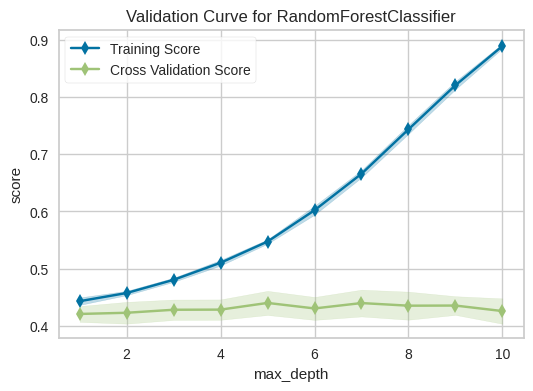

<Axes: title={'center': 'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [56]:
# Curva de aprendizagem
from yellowbrick.model_selection import ValidationCurve

fig, ax = plt.subplots(figsize=(6, 4))
vc_viz = ValidationCurve(
RandomForestClassifier(n_estimators=100),
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    n_jobs=-1,
)

vc_viz.fit(X=X_train, y=y_train)
vc_viz.poof()
#fig.savefig("images/mlpr_1101.png", dpi=300)

# O gráfico mostra as instâncias de treinamento e a pontuação para
# validação cruzada à medida que criamos modelos com mais amostras. 
# Se a pontuação da validação cruzada continuar a subir, por exemplo, poderá ser
# um sinal de que mais dados ajudariam o modelo a ter um melhor desempenho.

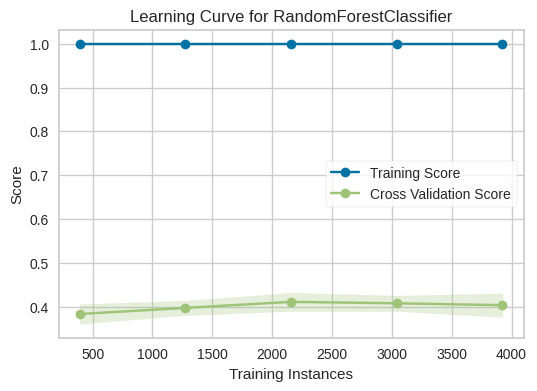

<Axes: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [57]:
from yellowbrick.model_selection import LearningCurve

fig, ax = plt.subplots(figsize=(6, 4))
lc3_viz = LearningCurve(
    RandomForestClassifier(
        n_estimators=100),
        cv=10,
    )

lc3_viz.fit(X_train, y_train)
lc3_viz.poof()
#fig.savefig("images/mlpr_1102.png", dpi=300)

---

In [42]:

df_pred_conf[df_pred_conf['conf']>=40]['is_hit'].value_counts(normalize=True)

is_hit
False    0.540984
True     0.459016
Name: proportion, dtype: float64

### Filtrando por IDX espesifico

In [43]:
df_pred_confIDX = df_pred_conf#[df_pred_conf['idx']==278]

df_selected_pred_confIDX = df_pred_confIDX[df_pred_confIDX['conf']>=80]#['is_hit'].value_counts(normalize=True)

y_pred_crop = df_selected_pred_confIDX['y_pred'].values
y_true_crop = df_selected_pred_confIDX['y_true'].values

acc_crop = accuracy_score(y_pred=y_pred_crop, 
               y_true=y_true_crop)

acc_oficial = accuracy_score(y_pred=df_pred_confIDX['y_pred'].values, 
               y_true=df_pred_confIDX['y_true'].values)

round(acc_crop*100, 2), round(acc_oficial*100, 2)

(50.59, 45.35)

In [44]:
df_selected_pred_confIDX[df_selected_pred_confIDX['y_pred']==0]

,idx,algorithm,y_true,y_pred,conf,is_hit
918,38,KNN,2,0,100.0,False
984,104,KNN,0,0,80.0,True
986,106,KNN,0,0,100.0,True
992,112,KNN,1,0,80.0,False
994,114,KNN,1,0,80.0,False
1018,138,KNN,2,0,80.0,False
1037,157,KNN,0,0,80.0,True
1069,189,KNN,1,0,80.0,False
1073,193,KNN,0,0,100.0,True
1078,198,KNN,1,0,80.0,False


In [45]:
df_pred_confIDX

,idx,algorithm,y_true,y_pred,conf,is_hit
0,0,Logistic Regression,2,0,46.0,False
1,1,Logistic Regression,0,1,62.0,False
2,2,Logistic Regression,0,1,46.0,False
3,3,Logistic Regression,0,1,72.0,False
4,4,Logistic Regression,2,1,49.0,False
...,...,...,...,...,...,...
1975,215,XGBoost,0,1,59.0,False
1976,216,XGBoost,0,0,48.0,True
1977,217,XGBoost,1,1,69.0,True
1978,218,XGBoost,1,2,72.0,False


In [48]:
#df_concat_preds_valid = concat_preds(list_model=list_pred_results)
#
#df_ensemble_valid = create_model_ensemble(df_concat_preds=df_concat_preds_valid,
#                                          y_true=y_valid)
#
#df_ensemble_valid

In [49]:
#df_ensemble_valid['acertos_mode'] = df_ensemble_valid['pred_mode'] == df_ensemble_valid['y_true']
#df_ensemble_valid['acertos_mode'].value_counts(normalize=True)

In [ ]:
metrics_multiclass = get_metrics_multiclass(y_pred=df_concat_preds_valid['pred_mode'], y_true=y_valid.values)

precision_multiclass=get_precision_multiclass(metrics_multiclass=metrics_multiclass)
show_print_precision_multiclass(precision_multiclass=precision_multiclass)

Reultados (precisão)
          
    Home_team: ------ 48.0%
    Draw: ----------- 53.0%
    Away_team: ------ 34.0%


In [ ]:
# Este é a proporção de distribuição REAL dos dados
show_print_precision_multiclass(precision_multiclass=df['winner'].value_counts(normalize=True).to_dict())

Reultados (precisão)
          
    Home_team: ------ 49.42%
    Draw: ----------- 26.64%
    Away_team: ------ 23.95%


---

## Realizando apostas com o melhor modelo usando dados de validação

1- Realizar apostas
    - Mandar df com os dados para realizar a previsão
    - Retornar df com predições e confiança do modelo

2- Checar resultados
    - Obter todas as metricas

In [ ]:
# Função para realizar apostas com os dados de validação seria legal 

df_jogos_apostas = df_valid.copy()#.iloc[0:6].copy()

y_jogos_apostas = df_jogos_apostas['winner']
df_jogos_apostas.drop(columns='winner', inplace=True)

In [ ]:

#df_jogos_apostas['y_conf'] = list_preds['y_pred']
#df_jogos_apostas['y_conf'] = list_preds['y_conf']

In [ ]:
import numpy as np

def open_list_preds_conf(list_pred_results):
    """
    Explora a lista de predições com confianças e retorna uma lista com as predições com mais confiança
    """

    # Vai selecionar os modelos com a confiança maior que o trash
    list_pred_conf = []
    for pred_results in list_pred_results:
        #print(pred_results['algorithm'])

        for idx, conf in enumerate(pred_results['conf']):
            y_pred = np.argmax(conf)
            conf = round(conf[y_pred] * 100, 0)
            #print(f"y: {y}, y_pred: {y_pred}, conf: {conf}%, is_hit: {y==y_pred}")

            list_pred_conf.append({'idx':idx,
                                    'algorithm':pred_results['algorithm'],
                                'y_pred':y_pred,
                                'conf':conf,
                                })

    df_pred_conf = pd.DataFrame(list_pred_conf)

    list_preds = {'y_pred':[], 'y_conf':[]}
    for idx in df_pred_conf['idx'].unique():
        threshold = 80

        query = df_pred_conf[(df_pred_conf['idx']==3) & (df_pred_conf['conf']>=threshold)]

        y_pred = query['y_pred'].mode().iloc[0]
        y_conf = query['conf'].mean()

        list_preds['y_pred'].append(y_pred)
        list_preds['y_conf'].append(y_conf)

    return list_preds

def realizar_aposta(df_apostas):
    """
    Realiza a predição de apostas esportivas

    Retorna uma lista contendo o resultado da predição

    Realiza a predição e obtem a confiança de varios modelos e por fim retorna uma lista com as predições com mais confiança
    """
    # Tratar dados 

    X_data_trans_scaler = get_data_transform(df_apostas, rfe, get_y_true=False)


    # Realiza o a predição com varios modelos
    list_pred_results = []
    for idx, dict_model in enumerate(list_model):
        mdl = dict_model['mdl']

        pred = mdl.predict(X_data_trans_scaler)
        conf = mdl.predict_proba(X_data_trans_scaler)
        
        dict_pred_results = {}
        dict_pred_results['algorithm'] = dict_model['algorithm']
        dict_pred_results['home_team_precision_%'] = None
        dict_pred_results['draw_precision_%'] = None
        dict_pred_results['away_team_precision_%'] = None
        dict_pred_results['mdl'] = mdl 
        dict_pred_results['accuracy'] = None
        dict_pred_results['pred'] = pred
        dict_pred_results['conf'] = conf


        list_pred_results.append(dict_pred_results)
        #print(f'{dict_model["algorithm"]}: {acc}%')

        
    list_preds = open_list_preds_conf(list_pred_results)

    df_apostas['y_pred'] = list_preds['y_pred']
    df_apostas['y_conf'] = list_preds['y_conf']

    #df_apostas['conf'] = dict_pred_results['conf']

    return df_apostas


def checar_apostas(df_apostas_with_preds, y_true):
    
    accuracy = accuracy_score(y_pred=df_apostas_with_preds['y_pred'], 
               y_true=y_true)
    
    df_apostas_with_preds['y_true'] = y_true
    df_apostas_with_preds['is_hit'] = df_apostas_with_preds['y_pred'] == y_true
    
    
    print(f'Acuracia de acertos: {round(accuracy*100, 2)}')

    return df_apostas_with_preds

In [ ]:
df_jogos_apostas = realizar_aposta(df_apostas=df_jogos_apostas)

#df_jogos_apostas = checar_apostas(df_apostas_with_preds=df_jogos_apostas,
#               y_true=y_jogos_apostas)


df_jogos_apostas

,season,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_points,ht_goals,ht_l_goals,ht_l_wavg_goals,ht_goals_sf,ht_l_goals_sf,ht_l_wavg_goals_sf,ht_wins,ht_draws,ht_losses,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_points,at_goals,at_l_goals,at_l_wavg_goals,at_goals_sf,at_l_goals_sf,at_l_wavg_goals_sf,at_wins,at_draws,at_losses,at_win_streak,at_loss_streak,at_draw_streak,ls_winner_-33,ls_winner_AWAY_TEAM,y_pred,y_conf
380,2023,8,3.0,7.0,3,1.000000,3.000000,3,1.000000,3.000000,0,1.000000,0.000000,1,0,0,1,0,0,7,7.0,7.0,3,1.000000,3.000000,2,0.666667,2.000000,0,0.000000,0.000000,1,0,0,1,0,0,False,True,2,80.0
381,2023,5,11.0,9.0,18,2.000000,2.250000,14,4.666667,1.406250,6,2.333333,0.593750,6,0,1,1,0,0,20,10.0,9.0,4,1.333333,1.625000,7,2.333333,1.375000,18,4.666667,2.062500,1,1,5,1,0,0,False,True,2,80.0
382,2023,9,2.0,7.0,21,1.333333,0.946533,13,4.333333,0.410767,16,3.333333,1.190674,6,3,5,0,1,0,1,1.0,7.0,24,0.666667,0.909912,25,8.333333,1.126465,13,6.333333,1.214478,6,6,2,0,0,2,False,True,2,80.0
383,2023,7,7.0,7.0,20,1.333333,0.713745,18,6.000000,0.782715,18,4.333333,1.216064,6,2,6,0,1,0,16,-33.0,8.0,13,0.333333,0.740479,15,5.000000,1.009766,21,5.000000,1.341797,3,4,7,0,0,1,False,True,2,80.0
384,2023,18,13.0,12.0,27,0.666667,0.450007,25,8.333333,2.281223,37,10.000000,3.337611,6,9,11,0,1,0,11,9.0,12.0,35,2.333333,1.638788,31,10.333333,0.864850,27,7.000000,0.602856,9,8,9,0,0,1,False,True,2,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,2024,16,15.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,17,2.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,False,True,2,80.0
2739,2024,1,5.0,2.0,3,1.000000,1.500000,3,1.000000,1.500000,3,0.666667,1.500000,1,0,1,1,0,0,11,-33.0,3.0,4,1.333333,2.000000,3,1.000000,1.500000,1,0.333333,0.500000,1,1,0,1,0,0,False,True,2,80.0
2740,2024,9,3.0,3.0,2,0.666667,1.000000,1,0.333333,0.500000,1,0.333333,0.500000,0,2,0,0,0,2,8,14.0,3.0,4,1.333333,2.000000,4,1.333333,2.000000,3,1.000000,1.500000,1,1,0,0,0,1,False,True,2,80.0
2741,2024,3,7.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,15,12.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,False,True,2,80.0


In [ ]:
df_jogos_apostas

,season,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_points,ht_goals,ht_l_goals,ht_l_wavg_goals,ht_goals_sf,ht_l_goals_sf,ht_l_wavg_goals_sf,ht_wins,ht_draws,ht_losses,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_points,at_goals,at_l_goals,at_l_wavg_goals,at_goals_sf,at_l_goals_sf,at_l_wavg_goals_sf,at_wins,at_draws,at_losses,at_win_streak,at_loss_streak,at_draw_streak,ls_winner_-33,ls_winner_AWAY_TEAM,y_pred,y_true,is_hit
380,2023,8,3.0,7.0,3,1.000000,3.000000,3,1.000000,3.000000,0,1.000000,0.000000,1,0,0,1,0,0,7,7.0,7.0,3,1.000000,3.000000,2,0.666667,2.000000,0,0.000000,0.000000,1,0,0,1,0,0,False,True,2,2,True
381,2023,5,11.0,9.0,18,2.000000,2.250000,14,4.666667,1.406250,6,2.333333,0.593750,6,0,1,1,0,0,20,10.0,9.0,4,1.333333,1.625000,7,2.333333,1.375000,18,4.666667,2.062500,1,1,5,1,0,0,False,True,2,2,True
382,2023,9,2.0,7.0,21,1.333333,0.946533,13,4.333333,0.410767,16,3.333333,1.190674,6,3,5,0,1,0,1,1.0,7.0,24,0.666667,0.909912,25,8.333333,1.126465,13,6.333333,1.214478,6,6,2,0,0,2,False,True,2,0,False
383,2023,7,7.0,7.0,20,1.333333,0.713745,18,6.000000,0.782715,18,4.333333,1.216064,6,2,6,0,1,0,16,-33.0,8.0,13,0.333333,0.740479,15,5.000000,1.009766,21,5.000000,1.341797,3,4,7,0,0,1,False,True,2,2,True
384,2023,18,13.0,12.0,27,0.666667,0.450007,25,8.333333,2.281223,37,10.000000,3.337611,6,9,11,0,1,0,11,9.0,12.0,35,2.333333,1.638788,31,10.333333,0.864850,27,7.000000,0.602856,9,8,9,0,0,1,False,True,2,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,2024,16,15.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,17,2.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,False,True,2,2,True
2739,2024,1,5.0,2.0,3,1.000000,1.500000,3,1.000000,1.500000,3,0.666667,1.500000,1,0,1,1,0,0,11,-33.0,3.0,4,1.333333,2.000000,3,1.000000,1.500000,1,0.333333,0.500000,1,1,0,1,0,0,False,True,2,2,True
2740,2024,9,3.0,3.0,2,0.666667,1.000000,1,0.333333,0.500000,1,0.333333,0.500000,0,2,0,0,0,2,8,14.0,3.0,4,1.333333,2.000000,4,1.333333,2.000000,3,1.000000,1.500000,1,1,0,0,0,1,False,True,2,2,True
2741,2024,3,7.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,15,12.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,False,True,2,2,True


In [ ]:
pd.DataFrame(list_pred_results)

,algorithm,home_team_precision_%,draw_precision_%,away_precision_%,mdl,accuracy_%,pred,conf
0,Logistic Regression,54.0,50.0,32.0,LogisticRegression(max_iter=3000),47.0,"[0, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[0.5615647230496207, 0.18085231112892586, 0.2..."
1,Logistic Regression tune,58.0,53.0,31.0,"LogisticRegression(C=100, max_iter=3000, solve...",49.0,"[0, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[0.591601910855013, 0.1353547197542159, 0.273..."
2,Random Forest,28.0,50.0,37.0,"(DecisionTreeClassifier(max_features='sqrt', r...",36.0,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, 2, ...","[[0.29, 0.39, 0.32], [0.5, 0.21, 0.29], [0.41,..."
3,Gradient Boost,32.0,41.0,53.0,([DecisionTreeRegressor(criterion='friedman_ms...,40.0,"[0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, ...","[[0.5259835639489234, 0.36598580178585954, 0.1..."
4,KNN,30.0,43.0,34.0,KNeighborsClassifier(),35.0,"[0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...","[[0.8, 0.2, 0.0], [0.4, 0.0, 0.6], [0.2, 0.6, ..."
5,Naive Bayes,41.0,40.0,43.0,GaussianNB(),41.0,"[0, 0, 1, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, ...","[[0.8983123019655864, 0.07262937039954137, 0.0..."
6,Decision Tree (C5),26.0,38.0,45.0,"DecisionTreeClassifier(max_depth=48, max_featu...",34.0,"[1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 2, ...","[[0.35294117647058826, 0.47058823529411764, 0...."
7,Neural Network (MLP),36.0,57.0,31.0,MLPClassifier(max_iter=3000),40.0,"[0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0.7818775653652936, 0.2100199997372594, 0.00..."
8,XGBoost,38.0,42.0,43.0,"XGBClassifier(base_score=None, booster=None, c...",40.0,"[1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, ...","[[0.14951096, 0.63839555, 0.2120935], [0.39460..."


In [ ]:
list_pred_results = realizar_aposta(df_jogos_apostas)

pd.DataFrame(list_pred_results)

,season,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_points,ht_goals,ht_l_goals,ht_l_wavg_goals,ht_goals_sf,ht_l_goals_sf,ht_l_wavg_goals_sf,ht_wins,ht_draws,ht_losses,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_points,at_goals,at_l_goals,at_l_wavg_goals,at_goals_sf,at_l_goals_sf,at_l_wavg_goals_sf,at_wins,at_draws,at_losses,at_win_streak,at_loss_streak,at_draw_streak,ls_winner_-33,ls_winner_AWAY_TEAM,y_pred,y_true,is_hit
380,2023,8,3.0,7.0,3,1.000000,3.000000,3,1.000000,3.000000,0,1.000000,0.000000,1,0,0,1,0,0,7,7.0,7.0,3,1.000000,3.000000,2,0.666667,2.000000,0,0.000000,0.000000,1,0,0,1,0,0,False,True,2,2,True
381,2023,5,11.0,9.0,18,2.000000,2.250000,14,4.666667,1.406250,6,2.333333,0.593750,6,0,1,1,0,0,20,10.0,9.0,4,1.333333,1.625000,7,2.333333,1.375000,18,4.666667,2.062500,1,1,5,1,0,0,False,True,2,2,True
382,2023,9,2.0,7.0,21,1.333333,0.946533,13,4.333333,0.410767,16,3.333333,1.190674,6,3,5,0,1,0,1,1.0,7.0,24,0.666667,0.909912,25,8.333333,1.126465,13,6.333333,1.214478,6,6,2,0,0,2,False,True,2,0,False
383,2023,7,7.0,7.0,20,1.333333,0.713745,18,6.000000,0.782715,18,4.333333,1.216064,6,2,6,0,1,0,16,-33.0,8.0,13,0.333333,0.740479,15,5.000000,1.009766,21,5.000000,1.341797,3,4,7,0,0,1,False,True,2,2,True
384,2023,18,13.0,12.0,27,0.666667,0.450007,25,8.333333,2.281223,37,10.000000,3.337611,6,9,11,0,1,0,11,9.0,12.0,35,2.333333,1.638788,31,10.333333,0.864850,27,7.000000,0.602856,9,8,9,0,0,1,False,True,2,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,2024,16,15.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,17,2.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,False,True,2,2,True
2739,2024,1,5.0,2.0,3,1.000000,1.500000,3,1.000000,1.500000,3,0.666667,1.500000,1,0,1,1,0,0,11,-33.0,3.0,4,1.333333,2.000000,3,1.000000,1.500000,1,0.333333,0.500000,1,1,0,1,0,0,False,True,2,2,True
2740,2024,9,3.0,3.0,2,0.666667,1.000000,1,0.333333,0.500000,1,0.333333,0.500000,0,2,0,0,0,2,8,14.0,3.0,4,1.333333,2.000000,4,1.333333,2.000000,3,1.000000,1.500000,1,1,0,0,0,1,False,True,2,2,True
2741,2024,3,7.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,15,12.0,-33.0,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0,0,0,0,0,False,True,2,2,True


In [ ]:
list_pred_conf = create_list_pred_conf_T(list_pred_results, y_true_list=y_jogos_apostas)

TypeError: string indices must be integers

In [ ]:



df_pred_conf = pd.DataFrame(list_pred_conf)
df_pred_conf.head()

TypeError: string indices must be integers

In [ ]:
X_jogos_apostas_trans_scaler, y_jogos_apostas = get_data_transform(df_jogos_apostas, rfe)

list_pred_results = pred_models(list_model, X_jogos_apostas_trans_scaler, y_jogos_apostas)

pd.DataFrame(list_pred_results).head()

KeyError: "['winner'] not found in axis"

In [ ]:
list_pred_conf = create_list_pred_conf_T(list_pred_results, y_true_list=y_jogos_apostas)
df_pred_conf = pd.DataFrame(list_pred_conf)
df_pred_conf.head()

Acuracia oficial: 0.5925925925925926


,algorithm,y_true,y_pred,conf,is_hit
0,Logistic Regression 1,2,2,46.0,True
1,Logistic Regression 1,2,2,69.0,True
2,Logistic Regression 1,0,1,46.0,False
3,Logistic Regression 1,2,2,69.0,True
4,Logistic Regression 1,2,2,41.0,True


In [ ]:
threshold = 80

df_pred_confIDX = df_pred_conf[df_pred_conf['idx']==3]

df_selected_pred_confIDX = df_pred_confIDX[df_pred_confIDX['conf']>=threshold]#['is_hit'].value_counts(normalize=True)

#y_pred_crop = df_selected_pred_confIDX['y_pred'].values
#y_true_crop = df_selected_pred_confIDX['y_true'].values
#
#acc_crop = accuracy_score(y_pred=y_pred_crop, 
#               y_true=y_true_crop)
#
#acc_oficial = accuracy_score(y_pred=df_pred_confIDX['y_pred'].values, 
#               y_true=df_pred_confIDX['y_true'].values)
#
#round(acc_crop*100, 2), round(acc_oficial*100, 2)

df_selected_pred_confIDX

,idx,algorithm,y_true,y_pred,conf,is_hit
1855,3,KNN,2,2,80.0,True
2318,3,Naive Bayes,2,2,80.0,True
2781,3,Decision Tree (C5),2,2,88.0,True


,idx,algorithm,y_true,y_pred,conf,is_hit
1855,3,KNN,2,2,80.0,True
2318,3,Naive Bayes,2,2,80.0,True
2781,3,Decision Tree (C5),2,2,88.0,True


In [ ]:
df_jogos_apostas

,season,winner,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_points,ht_goals,ht_l_goals,ht_l_wavg_goals,ht_goals_sf,ht_l_goals_sf,ht_l_wavg_goals_sf,ht_wins,ht_draws,ht_losses,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_points,at_goals,at_l_goals,at_l_wavg_goals,at_goals_sf,at_l_goals_sf,at_l_wavg_goals_sf,at_wins,at_draws,at_losses,at_win_streak,at_loss_streak,at_draw_streak,ls_winner_-33,ls_winner_AWAY_TEAM
380,2023,2,8,3.0,7.0,3,1.000000,3.000000,3,1.000000,3.000000,0,1.000000,0.000000,1,0,0,1,0,0,7,7.0,7.0,3,1.000000,3.000000,2,0.666667,2.000000,0,0.000000,0.000000,1,0,0,1,0,0,False,True
381,2023,2,5,11.0,9.0,18,2.000000,2.250000,14,4.666667,1.406250,6,2.333333,0.593750,6,0,1,1,0,0,20,10.0,9.0,4,1.333333,1.625000,7,2.333333,1.375000,18,4.666667,2.062500,1,1,5,1,0,0,False,True
382,2023,0,9,2.0,7.0,21,1.333333,0.946533,13,4.333333,0.410767,16,3.333333,1.190674,6,3,5,0,1,0,1,1.0,7.0,24,0.666667,0.909912,25,8.333333,1.126465,13,6.333333,1.214478,6,6,2,0,0,2,False,True
383,2023,2,7,7.0,7.0,20,1.333333,0.713745,18,6.000000,0.782715,18,4.333333,1.216064,6,2,6,0,1,0,16,-33.0,8.0,13,0.333333,0.740479,15,5.000000,1.009766,21,5.000000,1.341797,3,4,7,0,0,1,False,True
384,2023,2,18,13.0,12.0,27,0.666667,0.450007,25,8.333333,2.281223,37,10.000000,3.337611,6,9,11,0,1,0,11,9.0,12.0,35,2.333333,1.638788,31,10.333333,0.864850,27,7.000000,0.602856,9,8,9,0,0,1,False,True
385,2023,2,1,1.0,3.0,66,2.333333,2.306939,62,20.666667,3.000835,32,13.333333,0.737921,19,9,8,1,0,0,8,3.0,4.0,56,3.000000,2.731951,49,16.333333,2.210298,43,11.000000,0.362353,16,8,12,3,0,0,False,True


In [ ]:
metrics_multiclass = get_metrics_multiclass(y_pred=df_pred_conf['y_pred'].values, 
                         y_true=df_pred_conf['y_true'].values)
precision_multiclass = get_precision_multiclass(metrics_multiclass=metrics_multiclass)

show_print_precision_multiclass(precision_multiclass=precision_multiclass)

Reultados (precisão)
          
    Home_team: ------ 71.0%
    Draw: ----------- 0.0%
    Away_team: ------ 0%


In [ ]:
# Criar uma função que retorne a predição com o vencedor e a confiança

df_jogos_apostas

,season,winner,ht_rank,ht_ls_rank,ht_days_ls_match,ht_points,ht_l_points,ht_l_wavg_points,ht_goals,ht_l_goals,ht_l_wavg_goals,ht_goals_sf,ht_l_goals_sf,ht_l_wavg_goals_sf,ht_wins,ht_draws,ht_losses,ht_win_streak,ht_loss_streak,ht_draw_streak,at_rank,at_ls_rank,at_days_ls_match,at_points,at_l_points,at_l_wavg_points,at_goals,at_l_goals,at_l_wavg_goals,at_goals_sf,at_l_goals_sf,at_l_wavg_goals_sf,at_wins,at_draws,at_losses,at_win_streak,at_loss_streak,at_draw_streak,ls_winner_-33,ls_winner_AWAY_TEAM
380,2023,2,8,3.0,7.0,3,1.000000,3.000000,3,1.000000,3.000000,0,1.000000,0.000000,1,0,0,1,0,0,7,7.0,7.0,3,1.000000,3.000000,2,0.666667,2.000000,0,0.000000,0.000000,1,0,0,1,0,0,False,True
381,2023,2,5,11.0,9.0,18,2.000000,2.250000,14,4.666667,1.406250,6,2.333333,0.593750,6,0,1,1,0,0,20,10.0,9.0,4,1.333333,1.625000,7,2.333333,1.375000,18,4.666667,2.062500,1,1,5,1,0,0,False,True
382,2023,0,9,2.0,7.0,21,1.333333,0.946533,13,4.333333,0.410767,16,3.333333,1.190674,6,3,5,0,1,0,1,1.0,7.0,24,0.666667,0.909912,25,8.333333,1.126465,13,6.333333,1.214478,6,6,2,0,0,2,False,True
383,2023,2,7,7.0,7.0,20,1.333333,0.713745,18,6.000000,0.782715,18,4.333333,1.216064,6,2,6,0,1,0,16,-33.0,8.0,13,0.333333,0.740479,15,5.000000,1.009766,21,5.000000,1.341797,3,4,7,0,0,1,False,True
384,2023,2,18,13.0,12.0,27,0.666667,0.450007,25,8.333333,2.281223,37,10.000000,3.337611,6,9,11,0,1,0,11,9.0,12.0,35,2.333333,1.638788,31,10.333333,0.864850,27,7.000000,0.602856,9,8,9,0,0,1,False,True
385,2023,2,1,1.0,3.0,66,2.333333,2.306939,62,20.666667,3.000835,32,13.333333,0.737921,19,9,8,1,0,0,8,3.0,4.0,56,3.000000,2.731951,49,16.333333,2.210298,43,11.000000,0.362353,16,8,12,3,0,0,False,True


In [ ]:
end

NameError: name 'end' is not defined

### Tunando modelos

In [ ]:
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize

from sklearn.metrics import accuracy_score

X_train = X_train_trans_scaler
y_train = y_train

X_test = X_test_trans_scaler
y_test = y_test

def train_and_save_preds(mdl, name_pred_save:str): 
    # Iremos treinar no X_train0
    mdl.fit(X_train, y_train)
    
    # Vamos prever no X_train1 (X_train1 nesse caso é dado de validação, pois é um dado fora da amostra de treino
    p = mdl.predict(X_test)

    # Salvando as previsões
    #model_name_train1 = os.path.join(MODELS_FILE_DIR, f"preds_train1", name_pred_save) 

    #jb.dump(p, model_name_train1)
    
    # Calculando a metrica (y_train1 nesse caso é dado de validação, pois é um dado fora da amostra de treino)
    metric = accuracy_score(y_true=y_test.values, y_pred=p)
    
    # Realizando previses para o X_val1
    #p = mdl.predict(X_val1)
    #model_name_val1 = os.path.join(MODELS_FILE_DIR, f"preds_val1", name_pred_save) 
    #jb.dump(p, model_name_val1)
    
    #p = mdl.predict(X_test)
    #model_name_test = os.path.join(MODELS_FILE_DIR, f"preds_test/linear_Reg_{C_value}_{multi_class}_{solver}_{penalty}.pkl.z") 
    #jb.dump(p, model_name_test)

    return metric   


def tune_random_forest(params):
    """
    Realiza o tune do modelo

    Realiza o treino em dados do nivel_0 e realiza previsões para dados de outros niveis
    """

    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_features = params[4]
    bootstrap = params[5]
    criterion = params[6]

    
        
    mdl = RandomForestClassifier(n_estimators = n_estimators,
                                max_depth = max_depth,
                                min_samples_split = min_samples_split,
                                min_samples_leaf = min_samples_leaf,
                                max_features = max_features,
                                bootstrap = bootstrap,
                                criterion = criterion)


    name_pred_save = f"random_forest_{n_estimators}_{max_depth}_{min_samples_split}_{min_samples_leaf}_{max_features}_{bootstrap}_{criterion}.pkl.z"
    metric = train_and_save_preds(mdl=mdl, 
                                  name_pred_save=name_pred_save)
                                  
    dict_param = {
        "n_estimators":n_estimators,
        "max_depth":max_depth,
        "min_samples_split":min_samples_split,
        "min_samples_leaf":min_samples_leaf,
        "max_features":max_features,
        "bootstrap":bootstrap,
        "criterion":criterion,
    }
    print(f"dict_param: {dict_param}")
    print(f"metric: {metric}")
    
    return -metric

# Definindo o espaço de busca
space = [
    Integer(50, 500, name='n_estimators'),  # Número de árvores na floresta
    Integer(5, 50, name='max_depth'),       # Profundidade máxima de cada árvore
    Integer(2, 20, name='min_samples_split'), # Número mínimo de amostras para dividir um nó
    Integer(1, 10, name='min_samples_leaf'),  # Número mínimo de amostras por folha
    Categorical(['sqrt', 'log2'], name='max_features'), # Número de características para divisão
    Categorical([True, False], name='bootstrap'), # Se usa ou não amostragem com reposição
    Categorical(['gini', 'entropy'], name='criterion') # Função de qualidade de divisão
]

# Chamando o otimizador
res = gp_minimize(tune_random_forest, 
                  space, 
                  random_state=0, 
                  verbose=1, 
                  n_calls=20)


Iteration No: 1 started. Evaluating function at random point.
dict_param: {'n_estimators': np.int64(317), 'max_depth': np.int64(43), 'min_samples_split': np.int64(17), 'min_samples_leaf': np.int64(9), 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}
metric: 0.4903508771929825
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.9886
Function value obtained: -0.4904
Current minimum: -0.4904
Iteration No: 2 started. Evaluating function at random point.
dict_param: {'n_estimators': np.int64(76), 'max_depth': np.int64(17), 'min_samples_split': np.int64(11), 'min_samples_leaf': np.int64(8), 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}
metric: 0.4763157894736842
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.4695
Function value obtained: -0.4763
Current minimum: -0.4904
Iteration No: 3 started. Evaluating function at random point.
dict_param: {'n_estimators': np.int64(202), 'max_depth': np.int64(34), 'min_samples_sp

In [ ]:
#tuning logistic regression
print('>>> Treinando GridSearchCV')
#parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
# 'fit_intercept': (True, False), 'solver' : ('newton-cg', 'sag', 'saga', 'lbfgs'), 'class_weight' : (None, 'balanced')}

parameters = space

clf = list_model[6]['mdl']
gs = GridSearchCV(clf, parameters, 
                  scoring='accuracy', 
                  cv=3,
                  )
start = time.time()

#printing best fits and time elapsed
gs.fit(X_train_trans_scaler, y_train)
print(gs.best_score_, gs.best_params_,  time.time() - start)

#testing models on unseen data 
tpred_lr = gs.best_estimator_.predict(X_test_trans_scaler)

>>> Treinando GridSearchCV


TypeError: Parameter grid is not a dict (Integer(low=50, high=500, prior='uniform', transform='identity'))

In [ ]:
get_precision(pred=tpred_lr, y_test=y_test)

In [ ]:
# Melhor etimador do GridSearchCV

gs.best_estimator_

LogisticRegression(C=10, fit_intercept=False, max_iter=3000)

In [ ]:
print('GridSearchCV: \n', classification_report(y_test, tpred_lr, digits = 3))
print('RandomForestClassifier: \n', classification_report(y_test, tpred_rf, digits = 3))
print('GradientBoostingClassifier: \n', classification_report(y_test, tpred_gb, digits = 3))
print('KNeighborsClassifier: \n', classification_report(y_test, tpred_knn, digits = 3))

GridSearchCV: 
               precision    recall  f1-score   support

           0      0.322     0.170     0.223       329
           1      0.426     0.611     0.502       298
           2      0.590     0.620     0.605       513

    accuracy                          0.488      1140
   macro avg      0.446     0.467     0.443      1140
weighted avg      0.470     0.488     0.468      1140

RandomForestClassifier: 
               precision    recall  f1-score   support

           0      0.291     0.495     0.366       329
           1      0.217     0.017     0.031       298
           2      0.460     0.499     0.479       513

    accuracy                          0.372      1140
   macro avg      0.323     0.337     0.292      1140
weighted avg      0.348     0.372     0.329      1140

GradientBoostingClassifier: 
               precision    recall  f1-score   support

           0      0.287     0.748     0.415       329
           1      0.145     0.054     0.078       298
   

## Usando dados de validação

In [ ]:

#df_X = df_X[featured_columns]

#X_valida = ref.transform(df_X)

X_valida = scaler.fit_transform(df_X)

# testing models on unseen data 
pred_lr = gs.best_estimator_.predict(X_valida)
pred_rf = rf.predict(X_valida)
pred_gb = gb.predict(X_valida)
pred_knn = knn.predict(X_valida)


In [ ]:
import numpy as np
df_valida_models = pd.DataFrame()

df_valida_models['pred_lr'] = pred_lr
df_valida_models['pred_rf'] = pred_rf
df_valida_models['pred_gb'] = pred_gb
df_valida_models['pred_knn'] = pred_knn

In [ ]:
for idx, row in df_valida_models.iterrows():
    pred_mode = row.mode()
        # Verificando se a moda é unimodal (apenas um valor)
    if len(pred_mode) == 1:
        # Se for unimodal, pegue o valor
        result = pred_mode.item()
        df_valida_models.loc[idx, 'pred_mode'] = result
    else:
        # Se for bimodal ou multimodal, trate como necessário (por exemplo, retornando None)
        result = row['pred_lr']
        df_valida_models.loc[idx, 'pred_mode'] = result

df_valida_models['pred_mode'] = df_valida_models['pred_mode'].astype(int)
df_valida_models['winner'] = winner.values

In [ ]:
df_valida_models['acertos_mode'] = df_valida_models['pred_mode'] == df_valida_models['winner']

df_valida_models['acertos_mode'].value_counts(normalize=True)

acertos_mode
True     0.522678
False    0.477322
Name: proportion, dtype: float64

In [ ]:
df_valida_models['is_hit_pred_lr'] = df_valida_models['pred_lr'] == df_valida_models['winner']
df_valida_models['is_hit_pred_rf'] = df_valida_models['pred_rf'] == df_valida_models['winner']
df_valida_models['is_hit_pred_gb'] = df_valida_models['pred_gb'] == df_valida_models['winner']
df_valida_models['is_hit_pred_knn'] = df_valida_models['pred_knn'] == df_valida_models['winner']


is_hit_pred_lr = df_valida_models['is_hit_pred_lr'].value_counts(normalize=True) 
is_hit_pred_rf = df_valida_models['is_hit_pred_rf'].value_counts(normalize=True) 
is_hit_pred_gb = df_valida_models['is_hit_pred_gb'].value_counts(normalize=True) 
is_hit_pred_knn = df_valida_models['is_hit_pred_knn'].value_counts(normalize=True)

is_hit_pred_lr, is_hit_pred_rf, is_hit_pred_gb, is_hit_pred_knn

(is_hit_pred_lr
 False    0.500593
 True     0.499407
 Name: proportion, dtype: float64,
 is_hit_pred_rf
 True     0.502966
 False    0.497034
 Name: proportion, dtype: float64,
 is_hit_pred_gb
 False    0.507711
 True     0.492289
 Name: proportion, dtype: float64,
 is_hit_pred_knn
 False    0.562278
 True     0.437722
 Name: proportion, dtype: float64)

In [ ]:
df_valida_models

,pred_lr,pred_rf,pred_gb,pred_knn,pred_mode,winner,acertos_mode,is_hit_pred_lr,is_hit_pred_rf,is_hit_pred_gb,is_hit_pred_knn
0,2,2,2,0,2,2,True,True,True,True,False
1,2,2,2,2,2,2,True,True,True,True,True
2,1,0,1,0,0,0,True,False,True,False,True
3,2,2,2,2,2,2,True,True,True,True,True
4,2,2,2,2,2,2,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
838,2,2,2,2,2,2,True,True,True,True,True
839,2,2,2,0,2,2,True,True,True,True,False
840,2,2,2,0,2,2,True,True,True,True,False
841,2,2,2,2,2,2,True,True,True,True,True


In [ ]:
df_valida_models[df_valida_models['acertos_mode'] == False]

,pred_lr,pred_rf,pred_gb,pred_knn,pred_mode,winner,acertos_mode,is_hit_pred_lr,is_hit_pred_rf,is_hit_pred_gb,is_hit_pred_knn
6,1,1,2,2,1,2,False,False,False,True,True
12,1,1,1,1,1,2,False,False,False,False,False
15,2,0,2,0,0,2,False,True,False,True,False
16,2,0,0,0,0,2,False,True,False,False,False
22,2,0,0,1,0,2,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
799,1,0,2,0,0,2,False,False,False,True,False
806,1,1,1,1,1,2,False,False,False,False,False
810,2,0,2,0,0,1,False,False,False,False,False
817,1,2,0,0,0,1,False,True,False,False,False


In [ ]:
MODEL_DIR

In [ ]:
1200 -

400

In [ ]:
40000 